# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [ ]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob
import random

In [ ]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
SPECIES_DATASET_SIZE = 1000

# assuming even split across all classes
def split_train_test(lendata, num_classes, percentage=0.8):
    images_per_class = int(lendata / num_classes)
    training_images_per_class = int(images_per_class * percentage)
    testing_images_count_per_class = images_per_class - training_images_per_class
    
    idx = 0
    idxs_train = []
    idxs_test = []
        
    for _ in range(int(num_classes)):
        idxs_train.extend(range(idx, idx + training_images_per_class))
        idx += training_images_per_class
        idxs_test.extend(range(idx, idx + testing_images_count_per_class))
        idx += testing_images_count_per_class
        
    return idxs_train, idxs_test

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA, len(Multiclass_labels_correspondances), 0.8)

class DatasetImage():
    
    def __init__(self,
                image,
                label):
        self.image = image
        self.label = label
    
# Implement the dataset class
class FishDataset(ImageFolder):
    
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        super().__init__(path_to_images)
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set
        
        self.idxs = idxs_train if train else idxs_test
        self.size = len(self.idxs)
        self.images = []
        self.class_idxs = {}
        
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])
        
        class_files = {}
        
        # get filenames
        for label in Multiclass_labels_correspondances:
            class_files[label] = sorted(glob.glob(f'{path_to_images}/{label}/*.png'))
        
        idx = 0
        
        for label in class_files.keys():
            self.class_idxs[label] = []
            
            for file in class_files[label]:
                if idx not in self.idxs:
                    idx += 1
                    continue
                    
                image = Image.open(file)
                image = transform(image)
                self.images.append(DatasetImage(image, label))
                self.class_idxs[label].append(len(self.images) - 1)
        
        
    def __len__(self):
        return self.size
        
    def __getitem__(self, idx):
        dataset_image = self.images[idx]
        return dataset_image.image, Multiclass_labels_correspondances[dataset_image.label]

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

In [ ]:
# Training set
img_path = './archive/Fish_Dataset/Fish_Dataset'
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)

In [ ]:
# Plot the number of samples per class
classes = list(Multiclass_labels_correspondances.keys())
counts = [len(dataset.class_idxs[c]) for c in classes]

plt.bar(classes, counts)
plt.xticks(range(len(classes)), classes, rotation=90)
plt.show()

In [ ]:
# Plot 1 sample from each of the five classes in the training set
figure, axis = plt.subplots(1, 5)

for i, c in enumerate(classes):
    idx = np.random.choice(dataset.class_idxs[c])
    image, label = dataset[idx]
    image = np.transpose(image.detach().numpy(), (1,2,0))
    axis[i].imshow(image)
    
plt.gcf().set_size_inches(15, 3)
plt.show()

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

The dataset is balanced as there is an equal number of images per class.

The dataset is not pre-processed. The fish are not centred, rotated the same direction, or normalised.

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [38]:
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()
        # 3x128x128
        # self.add_module("conv1", torch.nn.Conv2d(3, 1, (5,5), padding=2))
        # 1x128x128
        # self.add_module("sigmoid1", torch.nn.Sigmoid())
        # 1x128x128
        # self.add_module("pool1", torch.nn.AvgPool2d(2, stride=2))
        # 1x64x64
        # self.add_module("conv2", torch.nn.Conv2d(1, 1, (5,5)))
        # 1x60x60
        # self.add_module("sigmoid2", torch.nn.Sigmoid())
        # 1x60x60
        # elf.add_module("pool2", torch.nn.AvgPool2d(2, stride=2))
        # 1x30x30
        # self.add_module("flatten", torch.nn.Flatten())
        # 60
        # self.add_module("linear1", torch.nn.Linear(60, 30))
        # 30
        # self.add_module("linear2", torch.nn.Linear(30, 10))
        # 10
        # self.add_module("linear3", torch.nn.Linear(10, output_dims))
        
        # 3x128x128
        self.add_module("conv1", torch.nn.Conv2d(3, 1, (5,5), padding=2))
        # 1x128x128
        # self.add_module("sigmoid1", torch.nn.Sigmoid())
        self.add_module("pool1", torch.nn.AvgPool2d(2, stride=2))
        # 1x64x64
        self.add_module("conv2", torch.nn.Conv2d(1, 1, (5,5), padding=2))
        # 1x64x64
        # self.add_module("sigmoid2", torch.nn.Sigmoid())
        self.add_module("pool2", torch.nn.AvgPool2d(2, stride=2))
        # 1x32x32
        self.add_module("conv3", torch.nn.Conv2d(1, 1, (3,3), padding=1))
        # 1x32x32
        self.add_module("sigmoid3", torch.nn.Sigmoid())
        self.add_module("pool3", torch.nn.AvgPool2d(2, stride=2))
        # 1x16x16
        self.add_module("flatten", torch.nn.Flatten())
        # 1x256
        self.add_module("linear1", torch.nn.Linear(256, 64))
        self.add_module("linear2", torch.nn.Linear(64, 16))
        self.add_module("linear3", torch.nn.Linear(16, output_dims))

    def forward(self, x):
        for layer in self.children():
            x = layer(x)
        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [39]:
# Network
model = Net(output_dims=5) # one-hot output vector

# Loss function
criterion = torch.nn.L1Loss()

# Optimiser and learning rate
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

# Number of iterations for training
epochs = 10

In [35]:
# Training batch size
train_batch_size = 400

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
print("Loading training dataset...")
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
print("Loading testing dataset...")
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset, shuffle=True)
print("Done.")

Loading training dataset...
Loading testing dataset...
Done.


### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [40]:
full_loss_curve = []

for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for images, labels in train_dataloader:
        # Get a batch of training data and train the model
        pred = model(images)
        loss = criterion(pred, torch.nn.functional.one_hot(labels, num_classes=5))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_curve += [loss.item()]

    full_loss_curve.extend(loss_curve)
        
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

 10%|█████████▌                                                                                     | 1/10 [00:09<01:27,  9.71s/it]

--- Iteration 1: training loss = 0.2847 ---


 20%|███████████████████                                                                            | 2/10 [00:18<01:13,  9.22s/it]

--- Iteration 2: training loss = 0.2138 ---


 30%|████████████████████████████▌                                                                  | 3/10 [00:27<01:02,  8.92s/it]

--- Iteration 3: training loss = 0.2092 ---


 40%|██████████████████████████████████████                                                         | 4/10 [00:36<00:54,  9.06s/it]

--- Iteration 4: training loss = 0.2091 ---


 50%|███████████████████████████████████████████████▌                                               | 5/10 [00:45<00:44,  8.93s/it]

--- Iteration 5: training loss = 0.2079 ---


 60%|█████████████████████████████████████████████████████████                                      | 6/10 [00:53<00:34,  8.74s/it]

--- Iteration 6: training loss = 0.2073 ---


 70%|██████████████████████████████████████████████████████████████████▌                            | 7/10 [01:02<00:26,  8.75s/it]

--- Iteration 7: training loss = 0.2068 ---


 80%|████████████████████████████████████████████████████████████████████████████                   | 8/10 [01:11<00:17,  8.89s/it]

--- Iteration 8: training loss = 0.2074 ---


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 9/10 [01:20<00:08,  8.94s/it]

--- Iteration 9: training loss = 0.2086 ---


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.96s/it]

--- Iteration 10: training loss = 0.2093 ---


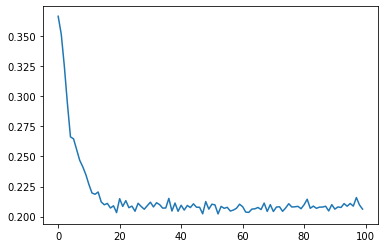

In [41]:
plt.plot(full_loss_curve)
plt.show()

### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [ ]:
# Deploy the model
model.train(mode=False)


### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [ ]:
#### ADD YOUR CODE HERE ####


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [ ]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
#### ADD YOUR CODE HERE ####

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [ ]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last(model)
# Modify the last layer. This layer is not freezed.
#### ADD YOUR CODE HERE ####

# Loss function
criterion =

# Optimiser and learning rate
lr =
optimizer =

# Number of iterations for training
epochs =

# Training batch size
train_batch_size =

### Step 4.3: Train and test your finetuned model. (5 points)

In [ ]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    #### ADD YOUR CODE HERE ####

# Deploy the model on the test set
#### ADD YOUR CODE HERE ####

# Evaluate the performance
#### ADD YOUR CODE HERE ####

### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

#### ADD YOUR RESPONSE HERE ####